# Initialize

In [2]:
%matplotlib inline
import yt
import yt.fields.vector_operations
from yt.units import dimensions, kboltz, mp
import os, sys, glob, errno
import matplotlib as mpl
#mpl.use("agg")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator
from scipy.interpolate import spline
import operator
import h5py
import mag_initialize as m


mu = 0.588
mu_e = 1.14
gamma = 5/3

a=0

def get_units(L):
    temp_str = str(L[-1:])
    k = temp_str.rfind("]") + 2
    return temp_str[k:]

def density(filename,groupname):
    return m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/density_mean"%groupname)[a:]  

def kT(filename,groupname):
    return m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/kT_mean"%groupname)[a:] 

# radial 
def velocity_r_variance(filename,groupname):
    v_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)[a:] 
    return v_r_stddev**2

# tangential
def velocity_t_variance(filename,groupname):
    v_theta_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)[a:] 
    v_phi_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)[a:]  
    return v_theta_stddev**2+v_phi_stddev**2

# filename is HDF5 file, groupname is 0500_profiles
def velocity_variance(filename,groupname):
    #v_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)
    #v_t_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)
    #v_p_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)    
    return velocity_r_variance(filename,groupname)+velocity_t_variance(filename,groupname)

# filename is HDF5 file, groupname is 0500_profiles
def mag_field_variance(filename,groupname):
    B_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_stddev"%groupname)[a:] 
    B_t_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_stddev"%groupname)[a:] 
    B_p_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_stddev"%groupname)[a:]     
    return B_r_stddev**2+B_t_stddev**2+B_p_stddev**2

# mean squared
def velocity_mean_sq(filename,groupname):
    v_r_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_mean"%groupname)[a:] 
    v_t_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_mean"%groupname)[a:] 
    v_p_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_mean"%groupname)[a:]     
    return v_r_mean**2+v_t_mean**2+v_p_mean**2

# mean squared
def mag_field_mean_sq(filename,groupname):
    B_r_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_mean"%groupname)[a:] 
    B_t_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_mean"%groupname)[a:] 
    B_p_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_mean"%groupname)[a:]     
    return B_r_mean**2+B_t_mean**2+B_p_mean**2

# sound speed sq
def c_s_sq(filename,groupname):
    return gamma*kT(filename,groupname)/(mu*mp)

# Alfven speed sq
def v_A_sq(filename,groupname):
    return (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))/(4*np.pi*density(filename,groupname))
    
def n_e(filename,groupname):
    return density(filename,groupname)/(mu_e*mp)
    
def S(filename,groupname):
    return kT(filename,groupname)/(n_e(filename,groupname))**(2/3)

def hopefully_constant(filename,groupname):
    B_sq = (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))
    return B_sq/(density(filename,groupname))**(4/3)

# Density Plots

[    7.16534917     7.58263082     8.02421329     8.49151179     8.9860239
     9.50933445    10.06312054    10.64915694    11.26932179    11.92560259
    12.6201026     13.35504754    14.13279277    14.95583081    15.82679934
    16.74848964    17.72385554    18.7560229     19.84829961    21.0041862
    22.22738707    23.52182232    24.89164037    26.34123121    27.8752405
    29.49858443    31.21646551    33.03438919    34.95818157    36.99400802
    39.14839297    41.42824079    43.84085794    46.39397638    49.09577837
    51.95492263    54.98057217    58.18242358    61.57073818    65.15637485
    68.95082483    72.96624859    77.21551478    81.71224146    86.47083973
    91.50655998    96.8355407    102.4748602    108.44259141   114.75785972
   121.44090431   128.51314303   135.99724101   143.91718331   152.29835176
   161.16760637   170.55337135   180.48572622   190.99650222   202.1193843
   213.89001911   226.34612922   239.52763399   253.47677755   268.23826415
   283.85940144 

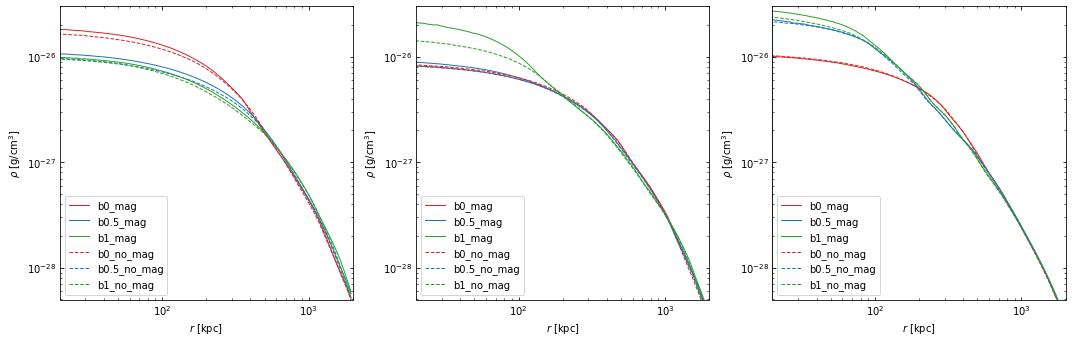

In [5]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

a=00

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=5e-29
ylim2=3e-26
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
# #ax1.tick_params(direction='in',top='on',right='on')

# ax1 = m.plt.subplot(131)
# ax2 = m.plt.subplot(132)
# ax3 = m.plt.subplot(133)


axes = [ax1, ax2, ax3]

print(radius, len(radius))
print(density(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), len(density(SIM_TYPE11_no_mag,"profiles_0500")))

# magnetic
line_11_mag, =ax1.plot(radius, density(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, density(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, density(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, density(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, density(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, density(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, density(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_32_mag, =ax3.plot(radius, density(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_33_mag, =ax3.plot(radius, density(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, density(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_12_no_mag, =ax1.plot(radius, density(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_13_no_mag, =ax1.plot(radius, density(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
line_21_no_mag, =ax2.plot(radius, density(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_22_no_mag, =ax2.plot(radius, density(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_23_no_mag, =ax2.plot(radius, density(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
line_31_no_mag, =ax3.plot(radius, density(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_32_no_mag, =ax3.plot(radius, density(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_33_no_mag, =ax3.plot(radius, density(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")

ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=3)
#ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=3)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=3)

#ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=3)
ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=3)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel(r"$\rho$ [g/cm$^3$]") #% get_units(density(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

In [ ]:
density(SIM_TYPE11_no_mag,"profiles_0500_80b")

# Entropy Plots

/home/jzuhone/Source/yt/yt/units/yt_array.py:1135: RuntimeWarning: invalid value encountered in true_divide
  return super(YTArray, self).__truediv__(ro)


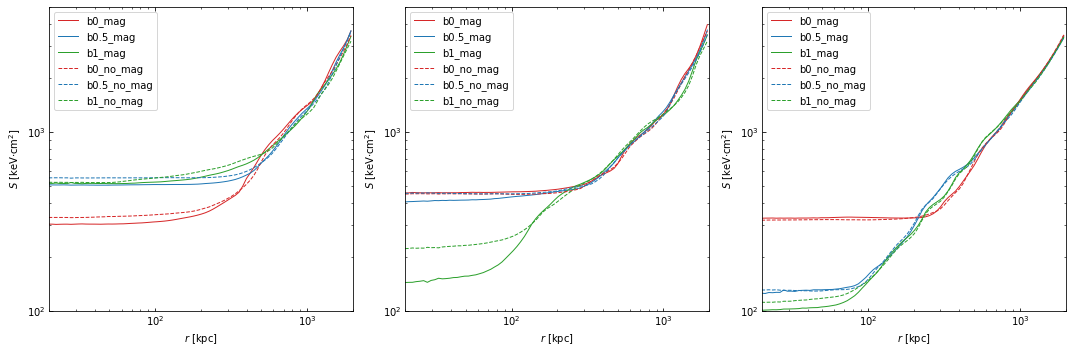

In [6]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e2
ylim2=5e3
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, S(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, S(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, S(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, S(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, S(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, S(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, S(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_32_mag, =ax3.plot(radius, S(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_33_mag, =ax3.plot(radius, S(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, S(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_12_no_mag, =ax1.plot(radius, S(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_13_no_mag, =ax1.plot(radius, S(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
line_21_no_mag, =ax2.plot(radius, S(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_22_no_mag, =ax2.plot(radius, S(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_23_no_mag, =ax2.plot(radius, S(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
line_31_no_mag, =ax3.plot(radius, S(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_32_no_mag, =ax3.plot(radius, S(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_33_no_mag, =ax3.plot(radius, S(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")

ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=2)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=2)

ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=2)

# ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=2)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=2)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')
    
    plot_ax.set_ylabel("$S$ [keV$\cdot$cm$^2$]") #% get_units(S(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

# Velocity Dispersion to Sound Speed Plots

/home/jzuhone/Source/yt/yt/units/yt_array.py:1135: RuntimeWarning: invalid value encountered in true_divide
  return super(YTArray, self).__truediv__(ro)


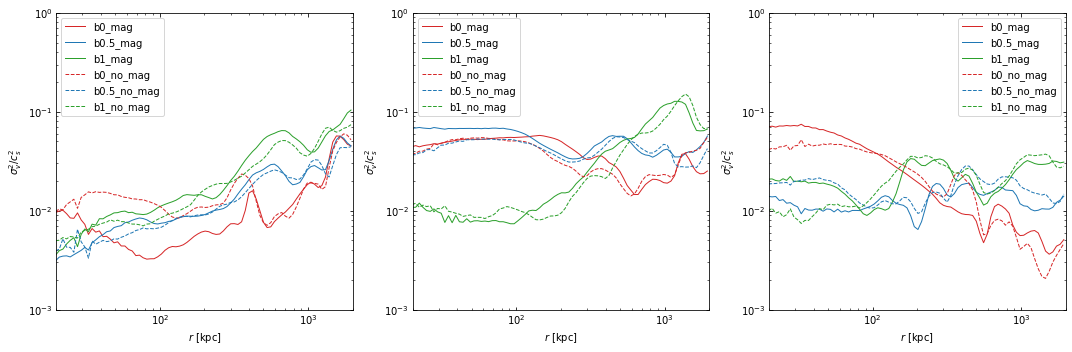

In [7]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e-3
ylim2=1e0
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix")/c_s_sq(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_32_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_33_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_12_no_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_13_no_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
line_21_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_22_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_23_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
line_31_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_32_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_33_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")

ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=2)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=2)

ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=1)

# ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=2)

# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=1)


#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$\sigma_v^2/c_s^2$") #% get_units(velocity_variance(SIM_TYPE11_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE11_no_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

# Alfven Speed to Sound Speed Plots

/home/jzuhone/Source/yt/yt/units/yt_array.py:1135: RuntimeWarning: invalid value encountered in true_divide
  return super(YTArray, self).__truediv__(ro)


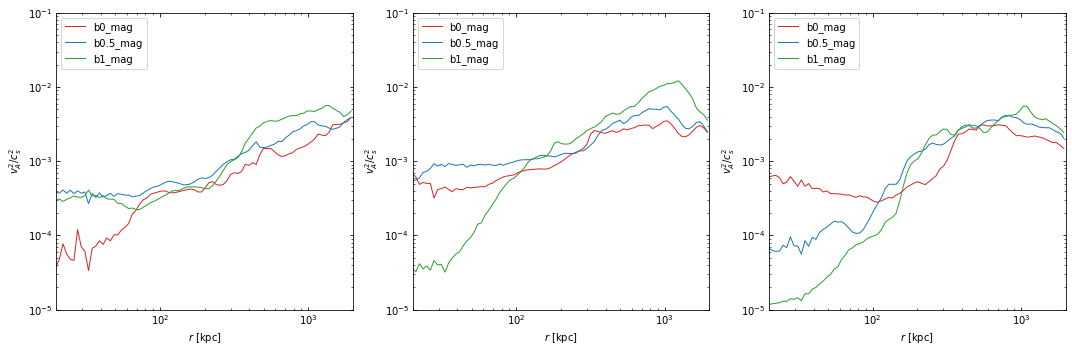

In [8]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e-5
ylim2=1e-1
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, v_A_sq(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, v_A_sq(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, v_A_sq(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, v_A_sq(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, v_A_sq(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, v_A_sq(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix")/c_s_sq(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, v_A_sq(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_32_mag, =ax3.plot(radius, v_A_sq(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_33_mag, =ax3.plot(radius, v_A_sq(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")

# ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=1)
# ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=1)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=1)
ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=2)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=2)
ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=2)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$v_A^2/c_s^2$") #% get_units(v_A_sq(SIM_TYPE11_mag,"profiles_0500")/c_s_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

# Velocity Dispersion to Alfven Speed

/home/jzuhone/Source/yt/yt/units/yt_array.py:1135: RuntimeWarning: invalid value encountered in true_divide
  return super(YTArray, self).__truediv__(ro)


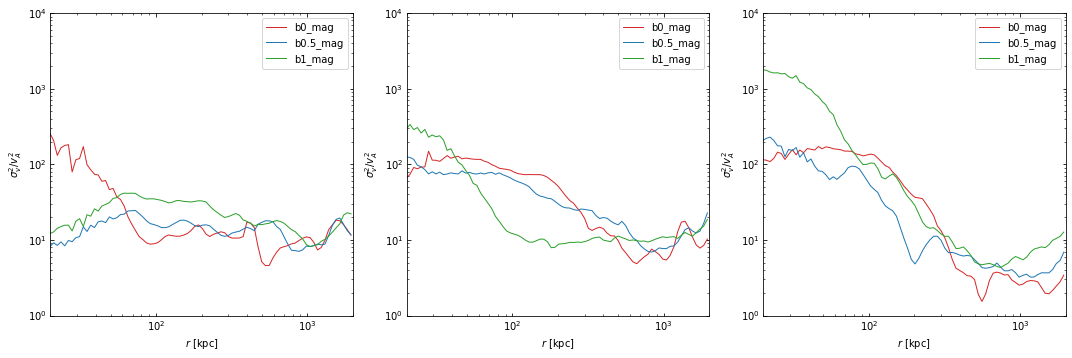

In [9]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e0
ylim2=1e4
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix")/v_A_sq(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_32_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_33_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")

# ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=1)
# ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=1)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=1)
ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=1)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=1)
ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=1)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$\sigma_v^2/v_A^2$") #% get_units(velocity_variance(SIM_TYPE11_mag,"profiles_0500")/v_A_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

# kT Plots

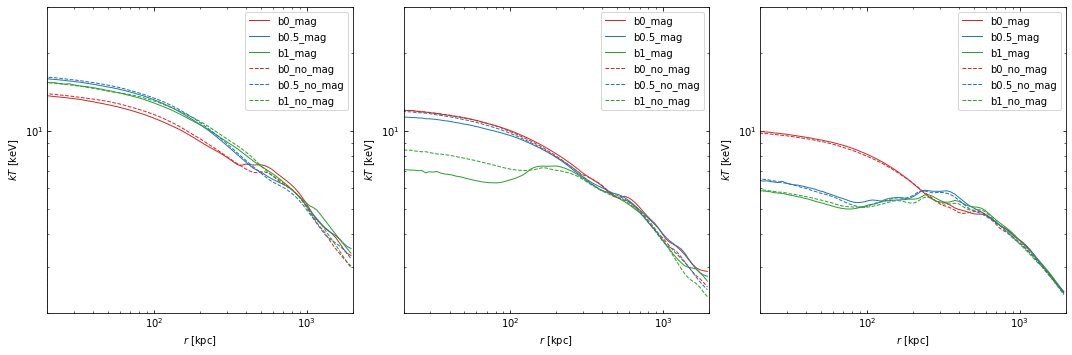

In [10]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=2e0
ylim2=3e1
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, kT(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, kT(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, kT(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, kT(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, kT(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, kT(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, kT(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_32_mag, =ax3.plot(radius, kT(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_33_mag, =ax3.plot(radius, kT(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, kT(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_12_no_mag, =ax1.plot(radius, kT(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_13_no_mag, =ax1.plot(radius, kT(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
line_21_no_mag, =ax2.plot(radius, kT(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_22_no_mag, =ax2.plot(radius, kT(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_23_no_mag, =ax2.plot(radius, kT(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
line_31_no_mag, =ax3.plot(radius, kT(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_32_no_mag, =ax3.plot(radius, kT(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_33_no_mag, =ax3.plot(radius, kT(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")

ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=1)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=1)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=1)
#ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=1)
#ax2.legend(handles=[line_21_mag,line_22_mag,line_21_no_mag], loc=1)
ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=1)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$kT$ [keV]") #% get_units(kT(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

Que?

In [ ]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

#xlim1=2e1
#xlim2=2e3
#ylim1=1e-5
#ylim2=1e-1
#num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))
num=1

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]



# magnetic
line_11_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE11_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
#line_12_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE12_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
#line_13_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE13_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")
#line_21_mag, =ax2.plot(radius, hopefully_constant(SIM_TYPE21_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
#line_22_mag, =ax2.plot(radius, hopefully_constant(SIM_TYPE22_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
#line_23_mag, =ax2.plot(radius, hopefully_constant(SIM_TYPE23_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")
#line_31_mag, =ax3.plot(radius, hopefully_constant(SIM_TYPE31_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
#line_32_mag, =ax3.plot(radius, hopefully_constant(SIM_TYPE32_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
#line_33_mag, =ax3.plot(radius, hopefully_constant(SIM_TYPE33_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")

# ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=1)
# ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=1)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=1)
ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=2)
ax2.legend(handles=[line_21_mag,line_22_mag], loc=2)
ax3.legend(handles=[line_31_mag], loc=2)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$hopefully_constant$") #% get_units(v_A_sq(SIM_TYPE11_mag,"profiles_0500")/c_s_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    #plot_ax.set_xlim(xlim1,xlim2)
    #plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

In [ ]:
def hopefully_constant(filename,groupname):
    B_sq = (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))
    return B_sq/(density(filename,groupname))**(4/3)

In [ ]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0000")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
#m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
#ylim1=1e21
#ylim2=1e25
#num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))
num=1

ax1 = m.plt.subplot(111)
axes=[ax1]

# magnetic
line_11_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE11_mag,"profiles_0000"), 'C3', lw=1, label="0 Gyr")
line_12_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE11_mag,"profiles_0250"), 'C0', lw=1, label="5 Gyr")
line_13_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE11_mag,"profiles_0500"), 'C2', lw=1, label="10 Gyr")
line_14_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE11_mag,"profiles_0400"), 'C2', lw=1, label="8 Gyr")

#line_21_mag, =ax2.plot(radius, hopefully_constant(SIM_TYPE21_mag,"profiles_0000"), 'C3', lw=1, label="b0_mag")
#line_22_mag, =ax2.plot(radius, hopefully_constant(SIM_TYPE22_mag,"profiles_0000"), 'C0', lw=1, label="b0.5_mag")
#line_23_mag, =ax2.plot(radius, hopefully_constant(SIM_TYPE23_mag,"profiles_0000"), 'C2', lw=1, label="b1_mag")
#line_31_mag, =ax3.plot(radius, hopefully_constant(SIM_TYPE31_mag,"profiles_0000"), 'C3', lw=1, label="b0_mag")
#line_32_mag, =ax3.plot(radius, hopefully_constant(SIM_TYPE32_mag,"profiles_0000"), 'C0', lw=1, label="b0.5_mag")
#line_33_mag, =ax3.plot(radius, hopefully_constant(SIM_TYPE33_mag,"profiles_0000"), 'C2', lw=1, label="b1_mag")

# ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=1)
# ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=1)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=1)
ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_14_mag], loc=2)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$hopefully_constant$") #% get_units(v_A_sq(SIM_TYPE11_mag,"profiles_0000")/c_s_sq(SIM_TYPE11_mag,"profiles_0000")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    #plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

In [ ]:
def vel_dispersion(filename,groupname):
    return velocity_variance(filename,groupname)**(1/2)

SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=5e1
ylim2=1e3
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))
#num=1

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, vel_dispersion(SIM_TYPE11_mag,"profiles_0500").in_units('km/s'), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, vel_dispersion(SIM_TYPE12_mag,"profiles_0500").in_units('km/s'), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, vel_dispersion(SIM_TYPE13_mag,"profiles_0500").in_units('km/s'), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, vel_dispersion(SIM_TYPE21_mag,"profiles_0500").in_units('km/s'), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, vel_dispersion(SIM_TYPE22_mag,"profiles_0500").in_units('km/s'), 'C0', lw=1, label="b0.5_mag")
#line_23_mag, =ax2.plot(radius, vel_dispersion(SIM_TYPE23_mag,"profiles_0500").in_units('km/s'), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, vel_dispersion(SIM_TYPE31_mag,"profiles_0500").in_units('km/s'), 'C3', lw=1, label="b0_mag")
#line_32_mag, =ax3.plot(radius, vel_dispersion(SIM_TYPE32_mag,"profiles_0500").in_units('km/s'), 'C0', lw=1, label="b0.5_mag")
#line_33_mag, =ax3.plot(radius, vel_dispersion(SIM_TYPE33_mag,"profiles_0500").in_units('km/s'), 'C2', lw=1, label="b1_mag")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, vel_dispersion(SIM_TYPE11_no_mag,"profiles_0500").in_units('km/s'), 'C3--', lw=1, label="b0_no_mag")
line_12_no_mag, =ax1.plot(radius, vel_dispersion(SIM_TYPE12_no_mag,"profiles_0500").in_units('km/s'), 'C0--', lw=1, label="b0.5_no_mag")
line_13_no_mag, =ax1.plot(radius, vel_dispersion(SIM_TYPE13_no_mag,"profiles_0500").in_units('km/s'), 'C2--', lw=1, label="b1_no_mag")
line_21_no_mag, =ax2.plot(radius, vel_dispersion(SIM_TYPE21_no_mag,"profiles_0500").in_units('km/s'), 'C3--', lw=1, label="b0_no_mag")
#line_22_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE22_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE22_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
#line_23_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE23_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE23_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")
#line_31_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE31_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE31_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
#line_32_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE32_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE32_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
#line_33_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE33_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE33_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")

# ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=1)
# ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=1)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=1)
ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=2)
ax2.legend(handles=[line_21_mag,line_22_mag,line_21_no_mag], loc=1)
ax3.legend(handles=[line_31_mag], loc=1)


#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$\sigma_v [km/s]$") #% get_units(vel_dispersion(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

In [ ]:
len(radius)

In [ ]:
print(density(SIM_TYPE22_mag,"profiles_0500"))

In [ ]:
density(SIM_TYPE11_mag,"profiles_0500")

In [ ]:
len(density(SIM_TYPE11_mag,"profiles_0500"))

In [ ]:
density(SIM_TYPE11_mag,"profiles_0500")[20:]

In [ ]:
density(SIM_TYPE11_no_mag,"profiles_0500")[20:]

In [ ]:
len(density(SIM_TYPE11_mag,"profiles_0500")[20:])

In [ ]:
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.70047936e-26   1.71911147e-26   1.70225475e-26   0.00000000e+00
   1.67726142e-26   1.69373621e-26   1.69952828e-26   1.67918474e-26
   1.68215624e-26   1.66571862e-26   1.66376727e-26   1.66491247e-26
   1.65317662e-26   1.62616331e-26   1.63049635e-26   1.62861564e-26
   1.61694072e-26   1.60185741e-26   1.58883517e-26   1.58147887e-26
   1.56536665e-26   1.54583748e-26   1.52790237e-26   1.50666498e-26
   1.48451423e-26   1.45970589e-26   1.43773268e-26   1.41094907e-26
   1.38430035e-26   1.35621600e-26   1.32442578e-26   1.29066761e-26
   1.25617738e-26   1.21979923e-26   1.18033530e-26   1.14109104e-26
   1.09874772e-26   1.05440227e-26   1.00789322e-26   9.60921627e-27
   9.13252716e-27   8.63013343e-27   8.10164970e-27   7.55056944e-27
   7.00189706e-27   6.44250793e-27   5.89118197e-27   5.35103698e-27
   4.82651434e-27   4.31706927e-27   3.81363361e-27   3.33943297e-27
   2.88622051e-27   2.45410969e-27   2.04195702e-27   1.69763956e-27
   1.43404951e-27   1.22074273e-27   1.03086866e-27   8.58852602e-28
   7.08399291e-28   5.84394615e-28   4.83299966e-28   3.99016826e-28
   3.24825969e-28   2.58974025e-28   1.99290639e-28   1.54249535e-28
   1.18911603e-28   9.08454883e-29   6.91433932e-29   5.15811584e-29] 

In [ ]:
no mag is giving me this?

[  1.72878837e-26   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.70047936e-26   1.71911147e-26   1.70225475e-26   0.00000000e+00
   1.67726142e-26   1.69373621e-26   1.69952828e-26   1.67918474e-26
   1.68215624e-26   1.66571862e-26   1.66376727e-26   1.66491247e-26
   1.65317662e-26   1.62616331e-26   1.63049635e-26   1.62861564e-26
   1.61694072e-26   1.60185741e-26   1.58883517e-26   1.58147887e-26
   1.56536665e-26   1.54583748e-26   1.52790237e-26   1.50666498e-26
   1.48451423e-26   1.45970589e-26   1.43773268e-26   1.41094907e-26
   1.38430035e-26   1.35621600e-26   1.32442578e-26   1.29066761e-26
   1.25617738e-26   1.21979923e-26   1.18033530e-26   1.14109104e-26
   1.09874772e-26   1.05440227e-26   1.00789322e-26   9.60921627e-27
   9.13252716e-27   8.63013343e-27   8.10164970e-27   7.55056944e-27
   7.00189706e-27   6.44250793e-27   5.89118197e-27   5.35103698e-27
   4.82651434e-27   4.31706927e-27   3.81363361e-27   3.33943297e-27
   2.88622051e-27   2.45410969e-27   2.04195702e-27   1.69763956e-27
   1.43404951e-27   1.22074273e-27   1.03086866e-27   8.58852602e-28
   7.08399291e-28   5.84394615e-28   4.83299966e-28   3.99016826e-28
   3.24825969e-28   2.58974025e-28   1.99290639e-28   1.54249535e-28
   1.18911603e-28   9.08454883e-29   6.91433932e-29   5.15811584e-29] g/cm**3 100